Aya Eid


Tempus Test Case

2/23/2020

My notes and justification for decisions are described below in headings and annotated throughout the code.  Please feel free to ask for more information if needed. 
Thank you.

# Include imports 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
%matplotlib inline

# Reading in and structuring data

Three files were provided and I assumed the features from the biomarkers file and those from the patient profiles were not redundant.  So in this section, I combine the features from biomarkers, the features from  patient profiles and the targets into a master data matrix, which I call "data".  

In [2]:
targets = pd.read_csv('targets.csv')
data = pd.read_csv('biomarkers.csv')

In [3]:
# Connect biomarker and target data through biomarker_id in master data matrix
data.insert(0,'patient_id', np.full(len(data),np.nan))
data.insert(1,'target', np.full(len(data),np.nan))

for b_iter in range(0, len(targets)):  
    bid = targets.loc[b_iter]['biomarker_id']  
    data.loc[data.biomarker_id==bid,'patient_id'] = targets.loc[b_iter,'patient_id']
    data.loc[data.biomarker_id==bid,'target'] = targets.loc[b_iter,'target_label']


In [4]:
data.head()

,patient_id,target,biomarker_id,BM00000,BM00001,BM00002,BM00003,BM00004,BM00005,BM00006,...,BM15147,BM15148,BM15149,BM15150,BM15151,BM15152,BM15153,BM15154,BM15155,BM15156
0,2293769a5,0.0,100505de2,1,1,1,0,0,0,1,...,1,0,1,1,0,0,1,1.0,1,1
1,221da90e,1.0,10075c5c2,1,1,1,0,0,0,1,...,1,0,0,0,0,0,1,NaN,1,1
2,f379252a,1.0,10105cb22,1,1,1,0,0,0,1,...,1,0,0,0,0,0,1,NaN,1,1
3,1c9af69ad,0.0,101219d6e,1,0,1,0,0,0,0,...,1,0,0,0,0,0,1,1.0,1,1
4,378b948f,0.0,10135ad45,1,0,1,0,1,0,1,...,1,0,1,0,0,0,1,1.0,1,1


In [5]:
# Next we connect the patient profile data to master data through the patient id  
# while this isn't the fastest, it could be optimized or parallelized for larger datasets
with open("patient_profiles.json", "r") as read_file:
    patient_profiles = json.load(read_file)

def check(val):
    if val:
        return val
    else:
        return np.nan
    
data['institution'] = np.full(len(data),np.nan)
data['gender'] = np.full(len(data),np.nan)
data['age'] = np.full(len(data),np.nan)
data['race'] = np.full(len(data),np.nan)
data['dst'] = np.full(len(data),np.nan)
data['comind'] = np.full(len(data),np.nan)
data['coq'] = np.full(len(data),np.nan)
data['smoking'] = np.full(len(data),np.nan)
data['msd'] = np.full(len(data),np.nan)

for inst_iter in range(0,len(patient_profiles)):
    print('Progress read in: ', inst_iter/(len(patient_profiles)-1))
          
    for p_iter in range(0,len(patient_profiles[inst_iter]['patient_profiles'])):           
        pid = patient_profiles[inst_iter]['patient_profiles'][p_iter]['patient_id']
        ploc = data['patient_id']==pid

        if(np.sum(ploc)>0):
            data.loc[data['patient_id']==pid,'institution'] = check(patient_profiles[inst_iter]['institution'])
            data.loc[data['patient_id']==pid,'gender'] = check(patient_profiles[inst_iter]['patient_profiles'][p_iter]['demographics'].get('gender'))
            data.loc[data['patient_id']==pid,'age'] = check(patient_profiles[inst_iter]['patient_profiles'][p_iter]['demographics'].get('age'))        
            data.loc[data['patient_id']==pid,'race'] = check(patient_profiles[inst_iter]['patient_profiles'][p_iter]['demographics'].get('race'))
            data.loc[data['patient_id']==pid,'dst'] = patient_profiles[inst_iter]['patient_profiles'][p_iter]['status'].get('disease_sub_type')
            
            data.loc[data['patient_id']==pid,'comind'] = check(patient_profiles[inst_iter]['patient_profiles'][p_iter]['status'].get('comorbidity_index'))
            data.loc[data['patient_id']==pid,'coq'] = check(patient_profiles[inst_iter]['patient_profiles'][p_iter]['status'].get('cohort_qualifier'))
            data.loc[data['patient_id']==pid,'smoking'] = check(patient_profiles[inst_iter]['patient_profiles'][p_iter]['status'].get('smoking_status'))
            data.loc[data['patient_id']==pid,'msd'] = check(patient_profiles[inst_iter]['patient_profiles'][p_iter]['status'].get('months_since_diagnosis'))
              

Progress read in:  0.0
Progress read in:  0.16666666666666666
Progress read in:  0.3333333333333333
Progress read in:  0.5
Progress read in:  0.6666666666666666
Progress read in:  0.8333333333333334
Progress read in:  1.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1960 entries, 0 to 1959
Columns: 15169 entries, patient_id to msd
dtypes: float64(50), int64(15111), object(8)
memory usage: 226.8+ MB


# Data Cleaning

Now I go through some basic approaches to ensuring the data can be handled by the model.  My process includes removing observations without targets, removing features that have too many missing values, and filling in missing values (although certain algorithms XGB for example could handle missing values).  For categorical data I used one-hot encoding to convert them into numerical inputs. 

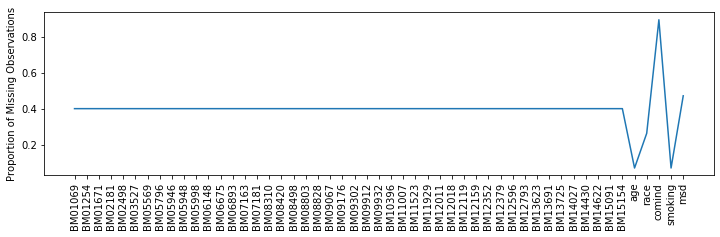

In [7]:
# Remove any observations without target data
dataCleaned = data.copy();
dataCleaned.dropna(subset=['target'],inplace=True)  

# Let's take a look at how many features have missing values
ratioOfNans = dataCleaned.isnull().sum()/len(dataCleaned)
plt.figure(figsize=(12,3))
plt.plot(ratioOfNans[ratioOfNans>0])
plt.xticks(rotation=90) 
plt.ylabel('Proportion of Missing Observations')
plt.show()

In [8]:
# For simplicity, let's just remove any features with more than 5% missing values
dataCleaned.dropna(axis=1, thresh = 100, inplace=True)

In [9]:
# Now for the categorical features, let's use one-hot encoding
cat_feats = ['institution','dst','gender','race','smoking']  

# Here I use a simple approach to ensuring the categories would bin appropriately (eg. MALE and male were considered the same observation)
dataCleaned = dataCleaned.applymap(lambda s:s.lower() if type(s) == str else s)  
dataCleaned = pd.get_dummies(dataCleaned, columns=cat_feats, drop_first=True)

# Here I found one feature that came from an input of "unknown" which is synomous with "NaN"
# another approach is to replace all table values of "unknown" with "NaN" earlier. But this was the only feature in which I saw this
dataCleaned.drop('smoking_unknown',axis=1,inplace=True)  
dataCleaned.fillna(0,inplace=True)  # not an ideal fill, but I wanted to keep it simple.  Also, XGBoost can handle them (future iteration)

In [10]:
# Let's take a look at the new features
dataCleaned.iloc[:,-25:].head()

,BM15153,BM15154,BM15155,BM15156,age,comind,coq,msd,institution_goodfellow research institute,institution_johnson & bloom hospitals,...,dst_d,dst_e,dst_f,gender_male,race_asian,race_black or african american,race_native hawaiian or other pacific islander,race_white,smoking_former,smoking_never
0,1,1.0,1,1,0.0,0.0,True,0.0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,1,0.0,1,1,29.0,0.0,True,79.0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,1,0.0,1,1,66.0,1.0,True,0.0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,1,1.0,1,1,69.0,0.0,True,0.0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,1,1.0,1,1,56.0,0.0,True,0.0,0,0,...,0,0,0,0,0,1,0,0,0,1


# Building a model

Now that the data is prepared, I made a couple first order attempts at building the model.  To do this I first separate training and test sets.  I started with a RF classifier to get a baseline of predictor strength.  It was clear the data was imbalanced and a boosted algorithm would improve the model.  I then used the Gradient Boosting Classifier and found marked improvement.  Finally, I performed some basic parameter tuning, which slightly improved the model.  

In [11]:
# First separate the data into test and train sets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
X = dataCleaned.drop(['target','biomarker_id','patient_id'],axis=1)
y = dataCleaned['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
# Here we get a feeling for how well a RF classifier will do
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=50, random_state=101)
model.fit(X_train, y_train)
predictions = np.round(model.predict(X_test))

print(classification_report(predictions, y_test))
print(confusion_matrix(predictions, y_test))

# We see here because this model is a bit imbalanced, 
# the best resulting model is as good as naively classifying all outputs as negatives. 
# While the TN rate is good, the TPR is terrible
# This is an ideal data set for a boosted approach 

              precision    recall  f1-score   support

         0.0       1.00      0.78      0.88       521
         1.0       0.00      0.00      0.00         0

    accuracy                           0.78       521
   macro avg       0.50      0.39      0.44       521
weighted avg       1.00      0.78      0.88       521

[[406 115]
 [  0   0]]


C:\Users\ayaei\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



Model Report
Accuracy : 0.8887
AUC Score (Test): 0.934
              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93       448
         1.0       0.57      0.89      0.69        73

    accuracy                           0.89       521
   macro avg       0.77      0.89      0.81       521
weighted avg       0.92      0.89      0.90       521


Confusion Matrix
[[398  50]
 [  8  65]]

Model Paramters
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='auto',
                           random_state=101, subsample=1.0, tol=0

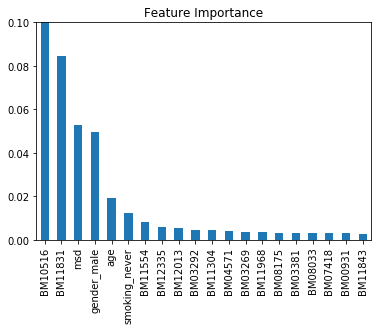

In [13]:
# Let's use GBM to improve upon this.  
# Again starting here with a baseline model, we use the default values
# and evaluate its performance 

from sklearn import metrics 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV

# First order model (no parameter tuning...yet)
model = GradientBoostingClassifier(random_state=101, n_estimators=50)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
pred_prob = model.predict_proba(X_test)[:,1]

# Print model report
print("\nModel Report")
print("Accuracy : %.4g" % metrics.accuracy_score(y_test, predictions))
print("AUC Score (Test): %4.3f" % metrics.roc_auc_score(y_test, pred_prob))
print(classification_report(predictions, y_test))

print("\nConfusion Matrix")
print(confusion_matrix(predictions, y_test))

print('\nModel Paramters')
print(model)

# Let's take a look at which features are playing the biggest role
f_imp = pd.Series(model.feature_importances_, list(X_train)).sort_values(ascending=False)
f_imp.iloc[0:20].plot(kind='bar', title='Feature Importance')
plt.ylim([0,.1])
plt.show()


Now let's do some basic tuning.  My process goes as follows.  First I consider the number of number of estimators or trees used to compute the model.  I want to personally cap it at 100 since I am limited by the computational power of my laptop. Let's ensure that the learning rate (LR) is appropriate for a max n_estimators of 100. 

Second, we can tune one or more tree parameters.  I chose only to look at max_depth.  When capped it should prevent overfitting and allow for a more generalizeable model. 

In [14]:
# Tuning n_estimators for a learning rate of 0.1
param_test = {'n_estimators':range(25,201,25)}
gsearch = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.1, 
                                                               min_samples_split = 2,
                                                               min_samples_leaf = 1,
                                                               max_depth = 3, 
                                                               max_features = None,
                                                               subsample = 0.8, 
                                                               random_state = 101), 
                        param_grid = param_test, scoring='roc_auc', n_jobs=4, iid=False, cv=5, verbose=1)
gsearch.fit(X_train,y_train)
n_estimators_B = gsearch.best_params_['n_estimators']
gsearch.best_params_, gsearch.best_score_


# Finding a value of 50 shows the LR may be just fine

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed: 12.1min finished


({'n_estimators': 50}, 0.9241551993190524)

In [15]:
# Let's tune max_depth to keep to smaller trees and prevent overfitting
param_test = {'max_depth':range(1,10,1)}
gsearch = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.1, 
                                                              n_estimators = n_estimators_B,
                                                              max_features = None,
                                                              min_samples_split = 2, 
                                                              min_samples_leaf = 1,
                                                              subsample = 0.8, 
                                                              random_state = 101), 
                        param_grid = param_test, scoring='roc_auc', n_jobs=4, iid=False, cv=3, verbose=1)
gsearch.fit(X_train,y_train)
max_depth_B = gsearch.best_params_['max_depth']
gsearch.best_params_, gsearch.best_score_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed:  8.8min finished


({'max_depth': 5}, 0.9264196321122791)


Model Report
Accuracy : 0.8925
AUC Score (Test): 0.926
              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93       444
         1.0       0.59      0.88      0.71        77

    accuracy                           0.89       521
   macro avg       0.78      0.89      0.82       521
weighted avg       0.92      0.89      0.90       521


Confusion Matrix
[[397  47]
 [  9  68]]

Model Paramters
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='auto',
                           random_state=101, subsample=0.8, tol=0

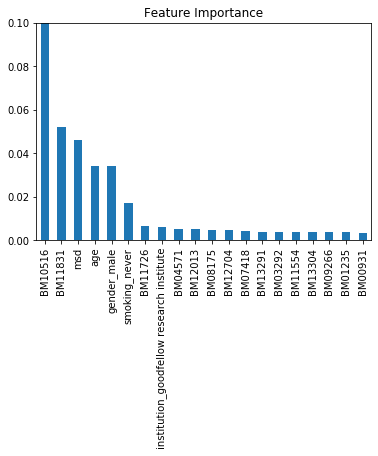

In [16]:
# Second order model, with new input values
model = GradientBoostingClassifier(random_state = 101, 
                                   learning_rate = 0.1, 
                                   n_estimators = n_estimators_B, 
                                   max_depth = max_depth_B, 
                                   min_samples_split = 2, 
                                   min_samples_leaf = 1,
                                   subsample = 0.8)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
pred_prob = model.predict_proba(X_test)[:,1]

# Print model report
print("\nModel Report")
print("Accuracy : %.4g" % metrics.accuracy_score(y_test, predictions))
print("AUC Score (Test): %4.3f" % metrics.roc_auc_score(y_test, pred_prob))
print(classification_report(predictions, y_test))

print("\nConfusion Matrix")
print(confusion_matrix(predictions, y_test))

print('\nModel Paramters')
print(model)

# Let's take a look at which features are playing the biggest role
f_imp = pd.Series(model.feature_importances_, list(X_train)).sort_values(ascending=False)
f_imp.iloc[0:20].plot(kind='bar', title='Feature Importance')
plt.ylim([0,.1])
plt.show()

At a bit of a cost to the TN rate, we see a marked improvement in the TP rate, yielding an overall improvement in accuracy.  We see this in an unchanged F1-score for targets of 0, and improved F1-sore for targets of 1.  Finally, as visualized in the figure, there is a slight shift in the order and importance of several features from the baseline model, although consistently, BM10516 is significantly more important than the others for optimal classification.  

In [18]:
# Finally let's save the model to share
import pickle
filename = 'tempus_model.pkl'
pickle.dump(model, open(filename, 'wb'))